# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# Define some constants

In [2]:
DEMOGRAPHICS_PATH = "./data/processed/demographics.csv"
RESPONDENTS_PATH = "./data/processed/all_respondents.csv"
SAVE_PLOT_PATH = "./plots/"
SAVE_PLOT = True

# Read in the processed data sets

In [3]:
demographics = pd.read_csv(DEMOGRAPHICS_PATH, parse_dates=["start_date", "end_date"], infer_datetime_format=True, dtype={"respondent_id": "object"})
all_respondents = pd.read_csv(RESPONDENTS_PATH, dtype={"respondent_id": "object"})

## Demographics dataset

The `demographics` dataset, which as the name suggests, contains the demographics information of all 53 respondents who completed all the questions on the survey.

**Disclaimer**: The demographic-related questions were designed to anonymize each individual response, as **no** names, emails or institution affiliations were collected. The 4 questions on demographics are about

1. Field of study
    * Materials Science
    * Physics
    * Chemistry
2. Highest academic degree held
    * BA/BS
    * MS
    * PhD
3. Research type
    * Experimental
    * Computational
    * Theoretical
4. Current position
    * Graduate student
    * Postdoc
    * Faculty
    * Staff scientist

In [101]:
demographics.head()

,respondent_id,accuracy,start_date,end_date,materials_science,chemistry,physics,highest_academic_degree_held,current_position,experimental,computational,theoretical
0,10991455189,0.333333,2019-09-13 13:11:00,2019-09-13 13:15:00,Materials Science,NaN,NaN,BA/BS,Graduate Student,NaN,Computational,Theoretical
1,10280657682,0.888889,2018-10-15 12:56:00,2018-10-15 13:03:00,Materials Science,NaN,NaN,PhD,Faculty,Experimental,NaN,NaN
2,10172361981,0.722222,2018-08-21 13:55:00,2018-08-21 14:17:00,Materials Science,NaN,Physics,PhD,Faculty,Experimental,NaN,NaN
3,10171054108,0.555556,2018-08-20 22:32:00,2018-08-20 22:50:00,Materials Science,NaN,NaN,PhD,Faculty,Experimental,NaN,NaN
4,10163866999,0.333333,2018-08-16 02:35:00,2018-08-16 02:41:00,Materials Science,NaN,NaN,MS,Graduate Student,NaN,Computational,NaN


In [5]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   respondent_id                 53 non-null     object        
 1   accuracy                      53 non-null     float64       
 2   start_date                    53 non-null     datetime64[ns]
 3   end_date                      53 non-null     datetime64[ns]
 4   materials_science             45 non-null     object        
 5   chemistry                     3 non-null      object        
 6   physics                       20 non-null     object        
 7   highest_academic_degree_held  53 non-null     object        
 8   current_position              53 non-null     object        
 9   experimental                  36 non-null     object        
 10  computational                 18 non-null     object        
 11  theoretical                   7 no

## All respondents dataset 

The `all_respondent` dataset contains the individual classification on the included 18 compounds, as well as the descriptors important to each respondent when classifying each compound.

In [6]:
all_respondents.head()

,respondent_id,formula,true_label,predicted_label,stoichiometry,crystal_structure,average_metal_oxygen_bond_distance,total_number_of_valence_electrons,d_electron_count,mass_density,mean_electronegativity_of_elements_in_formula,polarizability_of_the_compound,standard_deviation_of_average_ionic_radius_of_elements,crystal_field_splitting_energy,electronic_correlation,other_please_specify
0,10105286993,LaRuO3,metal,mit,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
1,10105286993,LaFeO3,insulator,mit,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
2,10105286993,LaNiO3,metal,mit,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
3,10105286993,CaFeO3,mit,insulator,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
4,10105286993,ReO3,metal,insulator,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN


In [7]:
all_respondents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   respondent_id                                           954 non-null    object
 1   formula                                                 954 non-null    object
 2   true_label                                              954 non-null    object
 3   predicted_label                                         954 non-null    object
 4   stoichiometry                                           469 non-null    object
 5   crystal_structure                                       548 non-null    object
 6   average_metal_oxygen_bond_distance                      275 non-null    object
 7   total_number_of_valence_electrons                       432 non-null    object
 8   d_electron_count                                  

# Demographics analysis

There are 53 respondents in total.

In [8]:
demographics.shape[0]

53

In [9]:
test_pivot = demographics.melt(id_vars=["respondent_id", "accuracy"], value_vars=["materials_science", "chemistry", "physics"], var_name="field_of_study")
test_pivot

,respondent_id,accuracy,field_of_study,value
0,10991455189,0.333333,materials_science,Materials Science
1,10280657682,0.888889,materials_science,Materials Science
2,10172361981,0.722222,materials_science,Materials Science
3,10171054108,0.555556,materials_science,Materials Science
4,10163866999,0.333333,materials_science,Materials Science
...,...,...,...,...
154,10129949550,0.388889,physics,NaN
155,10105717725,0.444444,physics,NaN
156,10105551544,0.277778,physics,NaN
157,10105461244,0.444444,physics,NaN


In [10]:
test_plot = test_pivot.dropna().drop(columns="value")

In [11]:
test_plot.value_counts(subset="field_of_study")

field_of_study
materials_science    45
physics              20
chemistry             3
dtype: int64

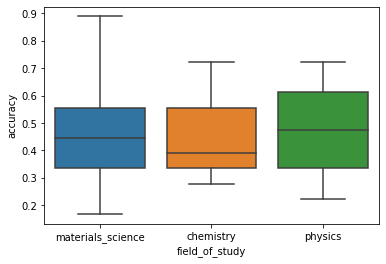

In [12]:
accuracy_by_field = sns.boxplot(data = test_plot, x="field_of_study", y="accuracy")

In [13]:
accuracy_by_field.set_xticklabels(["Materials Science", "Chemistry", "Physics"])

[Text(0, 0, 'Materials Science'),
 Text(1, 0, 'Chemistry'),
 Text(2, 0, 'Physics')]

In [14]:
accuracy_by_field.boxplot

<bound method Axes.boxplot of <AxesSubplot:xlabel='field_of_study', ylabel='accuracy'>>

-------------

In [96]:
def eval_performance(df_input, pos_class, groupby_col="respondent_id"):
    replace_dict = {"metal": 0, "insulator": 0, "mit": 0}
    replace_dict[pos_class] = 1
    
    df_eval = df_input.replace({"true_label": replace_dict, "predicted_label": replace_dict})
    
    def custom_score(df_subgroup, score_funcs, avg_method="weighted"):
        true_values = df_subgroup["true_label"]
        predicted_value = df_subgroup["predicted_label"]
        return [score_func(true_values, predicted_value, average=avg_method) for score_func in score_funcs]
    
    df_eval_grouped = df_eval.groupby(by=[groupby_col]).apply(func=custom_score, score_funcs=[precision_score, recall_score, f1_score])
    df_performance = pd.DataFrame(df_eval_grouped.to_list(), columns=["precision_weighted", "recall_weighted", "f1_weighted"])
    df_performance[groupby_col] = df_eval_grouped.index
    return df_performance[[groupby_col, "precision_weighted", "recall_weighted", "f1_weighted"]]

In [97]:
eval_performance(all_respondents, "insulator", "formula")

/Users/jasonrpw/PycharmProjects/mit_model_code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,formula,precision_weighted,recall_weighted,f1_weighted
0,Ag2BiO3,1.0,0.773585,0.872340
1,BaVS3,1.0,0.830189,0.907216
2,Ca2RuO4,1.0,0.849057,0.918367
3,CaFeO3,1.0,0.603774,0.752941
4,Cr2O3,1.0,0.547170,0.707317
5,KVO3,1.0,0.547170,0.707317
6,LaFeO3,1.0,0.377358,0.547945
7,LaNiO3,1.0,0.924528,0.960784
8,LaRuO3,1.0,0.849057,0.918367
9,MnO,1.0,0.452830,0.623377


--------

In [81]:
replace_dict = {"metal": 0, "insulator": 1, "mit": 0}

In [98]:
test_performance = all_respondents.replace({"true_label": replace_dict, "predicted_label": replace_dict})
test_performance.query('formula == "LaFeO3"')

,respondent_id,formula,true_label,predicted_label,stoichiometry,crystal_structure,average_metal_oxygen_bond_distance,total_number_of_valence_electrons,d_electron_count,mass_density,mean_electronegativity_of_elements_in_formula,polarizability_of_the_compound,standard_deviation_of_average_ionic_radius_of_elements,crystal_field_splitting_energy,electronic_correlation,other_please_specify
1,10105286993,LaFeO3,1,0,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
19,10105461244,LaFeO3,1,0,NaN,"Crystal structure (e.g. perovskite, rock salt,...",Average metal-oxygen bond distance,NaN,d electron count,Mass density,NaN,NaN,NaN,NaN,NaN,NaN
37,10105551544,LaFeO3,1,0,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,10105717725,LaFeO3,1,1,Stoichiometry,"Crystal structure (e.g. perovskite, rock salt,...",Average metal-oxygen bond distance,Total number of valence electrons,d electron count,Mass density,Mean electronegativity of elements in formula,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
73,10129949550,LaFeO3,1,0,Stoichiometry,"Crystal structure (e.g. perovskite, rock salt,...",Average metal-oxygen bond distance,Total number of valence electrons,d electron count,NaN,Mean electronegativity of elements in formula,Polarizability of the compound,NaN,Crystal field splitting energy,Electronic correlation,NaN
91,10141408673,LaFeO3,1,0,Stoichiometry,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,Polarizability of the compound,NaN,Crystal field splitting energy,NaN,NaN
109,10142736028,LaFeO3,1,1,Stoichiometry,"Crystal structure (e.g. perovskite, rock salt,...",NaN,NaN,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
127,10143192620,LaFeO3,1,1,Stoichiometry,"Crystal structure (e.g. perovskite, rock salt,...",Average metal-oxygen bond distance,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
145,10144033010,LaFeO3,1,1,NaN,NaN,NaN,NaN,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,NaN,NaN
163,10144105048,LaFeO3,1,1,NaN,NaN,Average metal-oxygen bond distance,NaN,NaN,NaN,NaN,Polarizability of the compound,NaN,NaN,NaN,NaN


In [100]:
precision_score(test_performance.query('formula == "LaFeO3"').true_label, test_performance.query('formula == "LaFeO3"').predicted_label)

1.0

In [ ]:
test_performance.query('formula == "LaFeO3"').predicted_label

In [92]:
all_respondents.query("true_label == 'insulator'")

,respondent_id,formula,true_label,predicted_label,stoichiometry,crystal_structure,average_metal_oxygen_bond_distance,total_number_of_valence_electrons,d_electron_count,mass_density,mean_electronegativity_of_elements_in_formula,polarizability_of_the_compound,standard_deviation_of_average_ionic_radius_of_elements,crystal_field_splitting_energy,electronic_correlation,other_please_specify
1,10105286993,LaFeO3,insulator,mit,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
6,10105286993,MoO3,insulator,insulator,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,NaN,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
9,10105286993,MnO,insulator,metal,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
12,10105286993,Sr2TiO4,insulator,mit,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
14,10105286993,Cr2O3,insulator,insulator,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,10991455189,MoO3,insulator,insulator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Crystal field splitting energy,NaN,NaN
945,10991455189,MnO,insulator,metal,NaN,NaN,Average metal-oxygen bond distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
948,10991455189,Sr2TiO4,insulator,mit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Crystal field splitting energy,NaN,NaN
950,10991455189,Cr2O3,insulator,metal,NaN,NaN,NaN,NaN,d electron count,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
test_performance.groupby(by=["formula"]).apply(func=custom_score, score_funcs=[precision_score, recall_score, f1_score])

formula
Ag2BiO3     [1.0, 0.7735849056603774, 0.8723404255319149]
BaVS3       [1.0, 0.8301886792452831, 0.9072164948453608]
Ca2RuO4     [1.0, 0.8490566037735849, 0.9183673469387755]
CaFeO3      [1.0, 0.6037735849056604, 0.7529411764705882]
Cr2O3       [1.0, 0.5471698113207547, 0.7073170731707317]
KVO3        [1.0, 0.5471698113207547, 0.7073170731707317]
LaFeO3     [1.0, 0.37735849056603776, 0.5479452054794521]
LaNiO3      [1.0, 0.9245283018867925, 0.9607843137254902]
LaRuO3      [1.0, 0.8490566037735849, 0.9183673469387755]
MnO         [1.0, 0.4528301886792453, 0.6233766233766234]
MoO2        [1.0, 0.7169811320754716, 0.8351648351648352]
MoO3        [1.0, 0.5660377358490566, 0.7228915662650602]
NbO2        [1.0, 0.6981132075471698, 0.8222222222222222]
ReO3        [1.0, 0.7358490566037735, 0.8478260869565217]
Sr2TiO4     [1.0, 0.5471698113207547, 0.7073170731707317]
SrCrO3      [1.0, 0.7169811320754716, 0.8351648351648352]
Ti2O3        [1.0, 0.660377358490566, 0.7954545454545454]
TiO   

In [83]:
def custom_score(row, score_funcs, avg_method="weighted"):
    true_values = row["true_label"]
    predicted_value = row["predicted_label"]
    return [score_func(true_values, predicted_value, average=avg_method) for score_func in score_funcs]

In [84]:
test_df = pd.DataFrame(test_performance.groupby(by=["formula"]).apply(func=custom_score, score_funcs=[precision_score, recall_score, f1_score]).to_list(), 
                       columns=["precision_weighted", "recall_weighted", "f1_weighted"])

/Users/jasonrpw/PycharmProjects/mit_model_code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
test_df["respondent_id"] = test_performance.groupby(by=["formula"]).apply(func=custom_score, score_funcs=[precision_score, recall_score, f1_score]).index

In [87]:
test_df = test_df[["respondent_id", "precision_weighted", "recall_weighted", "f1_weighted"]]

In [88]:
test_df

,respondent_id,precision_weighted,recall_weighted,f1_weighted
0,Ag2BiO3,1.0,0.773585,0.872340
1,BaVS3,1.0,0.830189,0.907216
2,Ca2RuO4,1.0,0.849057,0.918367
3,CaFeO3,1.0,0.603774,0.752941
4,Cr2O3,1.0,0.547170,0.707317
5,KVO3,1.0,0.547170,0.707317
6,LaFeO3,1.0,0.377358,0.547945
7,LaNiO3,1.0,0.924528,0.960784
8,LaRuO3,1.0,0.849057,0.918367
9,MnO,1.0,0.452830,0.623377
